### Import important libraries

In [1]:

import optuna
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

from sklearn.metrics import accuracy_score,recall_score,precision_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv('/Users/apple/Hotel_Reservation/hotel_reservation/data/raw/raw_data.csv')
raw_data.drop('Booking_ID', axis=1, inplace=True)
raw_data.head()

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0             2               0                     1                  2   
1             2               0                     2                  3   
2             1               0                     2                  1   
3             2               0                     0                  2   
4             2               0                     1                  1   

  type_of_meal_plan  required_car_parking_space room_type_reserved  lead_time  \
0       Meal Plan 1                           0        Room_Type 1        224   
1      Not Selected                           0        Room_Type 1          5   
2       Meal Plan 1                           0        Room_Type 1          1   
3       Meal Plan 1                           0        Room_Type 1        211   
4      Not Selected                           0        Room_Type 1         48   

   arrival_year  arrival_month  arrival_date market_segment_type  \
0          2017             10             2             Offline   
1          2018             11             6              Online   
2          2018              2            28              Online   
3          2018              5            20              Online   
4          2018              4            11              Online   

   repeated_guest  no_of_previous_cancellations  \
0               0                             0   
1               0                             0   
2               0                             0   
3               0                             0   
4               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled  
3                       0       Canceled  
4                       0       Canceled

In [3]:
# Create a profiling data report using ydata_profiling library
profile = ProfileReport(raw_data, title="Profiling Report")
profile.to_file("profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

From the profiling report we can see the data contains duplicate rows, thus we can drop those rows.

In [4]:
print(f"Shape of raw data before deleting duplicate rows: {raw_data.shape}")
raw_data.drop_duplicates(keep='first', ignore_index=True, inplace=True)
print(f"Shape of raw data after deleting duplicate rows: {raw_data.shape}")

Shape of raw data before deleting duplicate rows: (36275, 18)
Shape of raw data after deleting duplicate rows: (26000, 18)


While trying to make a full date column, it was found that there are 35 rows in the data where date is 29 Feb, since the data belongs to year 2017 and 2018, these dates cannot be possible as both 2017 and 2018 were not leap years, so we can drop those rows as well.

In [5]:
raw_data = raw_data.loc[~((raw_data['arrival_date']==29)&(raw_data['arrival_month']==2))].reset_index(drop=True)
print(f"Shape of raw data after deleting redundant rows: {raw_data.shape}")

Shape of raw data after deleting redundant rows: (25965, 18)


In [6]:
raw_data['arrival_full_date'] = pd.to_datetime(raw_data[['arrival_year', 'arrival_month', 'arrival_date']].rename(
        columns={'arrival_year': 'year', 'arrival_month': 'month', 'arrival_date': 'day'}))

# Create quarter column
raw_data['arrival_quarter'] = raw_data['arrival_full_date'].dt.quarter.map({
    1: "Jan-Mar",
    2: "Apr-Jun",
    3: "Jul-Sep",
    4: "Oct-Dec"
})

# Categorize weekdays (0 for Mon-Fri, 1 for Sat-Sun)
raw_data['is_weekend'] = raw_data['arrival_full_date'].dt.weekday >= 5

# Convert Boolean to integer (0 = Weekday, 1 = Weekend)
raw_data['is_weekend'] = raw_data['is_weekend'].astype(int)

booking_status
Not_Canceled    0.713653
Canceled        0.286347
Name: proportion, dtype: float64


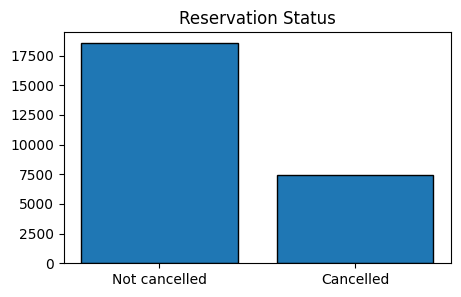

In [7]:
cancelation_pct = raw_data['booking_status'].value_counts(normalize=True)
print(cancelation_pct)

plt.figure(figsize = (5,3))
plt.title('Reservation Status')
plt.bar(['Not cancelled' , 'Cancelled'], raw_data['booking_status'].value_counts(), edgecolor = 'k')
plt.show()

Remarks: Looking at the distribution of target variable we can easily identify that the dataset is imbalanced.

Also the provided bar graph illustrates the cancellation and non-cancellation percentages for reservations. It is evident that a substantial portion of reservations remains unaffected by cancellations. Notably, 29% of clients have chosen to cancel their reservations, and this has a noteworthy impact on the hotels' revenue.

In [8]:
raw_data.columns

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status',
       'arrival_full_date', 'arrival_quarter', 'is_weekend'],
      dtype='object')

In [9]:
categorical_cols = ['type_of_meal_plan','required_car_parking_space',
       'room_type_reserved','market_segment_type', 'repeated_guest','booking_status', 'arrival_quarter', 'is_weekend']

numerical_cols = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights','lead_time', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests']

In [10]:
def show_unique_values(df):
    for column in df.columns:
        unique_values = df[column].unique()
        print(f"Unique values in '{column}':\n{unique_values}\n")
        
show_unique_values(raw_data[categorical_cols])

Unique values in 'type_of_meal_plan':
['Meal Plan 1' 'Not Selected' 'Meal Plan 2' 'Meal Plan 3']

Unique values in 'required_car_parking_space':
[0 1]

Unique values in 'room_type_reserved':
['Room_Type 1' 'Room_Type 4' 'Room_Type 2' 'Room_Type 6' 'Room_Type 5'
 'Room_Type 7' 'Room_Type 3']

Unique values in 'market_segment_type':
['Offline' 'Online' 'Corporate' 'Aviation' 'Complementary']

Unique values in 'repeated_guest':
[0 1]

Unique values in 'booking_status':
['Not_Canceled' 'Canceled']

Unique values in 'arrival_quarter':
['Oct-Dec' 'Jan-Mar' 'Apr-Jun' 'Jul-Sep']

Unique values in 'is_weekend':
[0 1]



## Exploratory Data Analysis

### Univariate Analysis

#### Numerical Features

In [11]:
def num_plot_dist(df, num_features):
        fig, axes = plt.subplots(len(num_features), 2, figsize=(12, len(num_features) * 4))
        if len(num_features) == 1:
            axes = [axes] 
        for i, column in enumerate(num_features):
            sns.histplot(data=df, x=column, ax=axes[i][0], kde=True, palette="Blues")
            axes[i][0].set_title(f'Histogram with KDE for {column}')
            
            sns.boxplot(data=df, x=column, ax=axes[i][1], palette="Blues")
            axes[i][1].set_title(f'Box Plot for {column}')
        
        plt.tight_layout()
        plt.show()

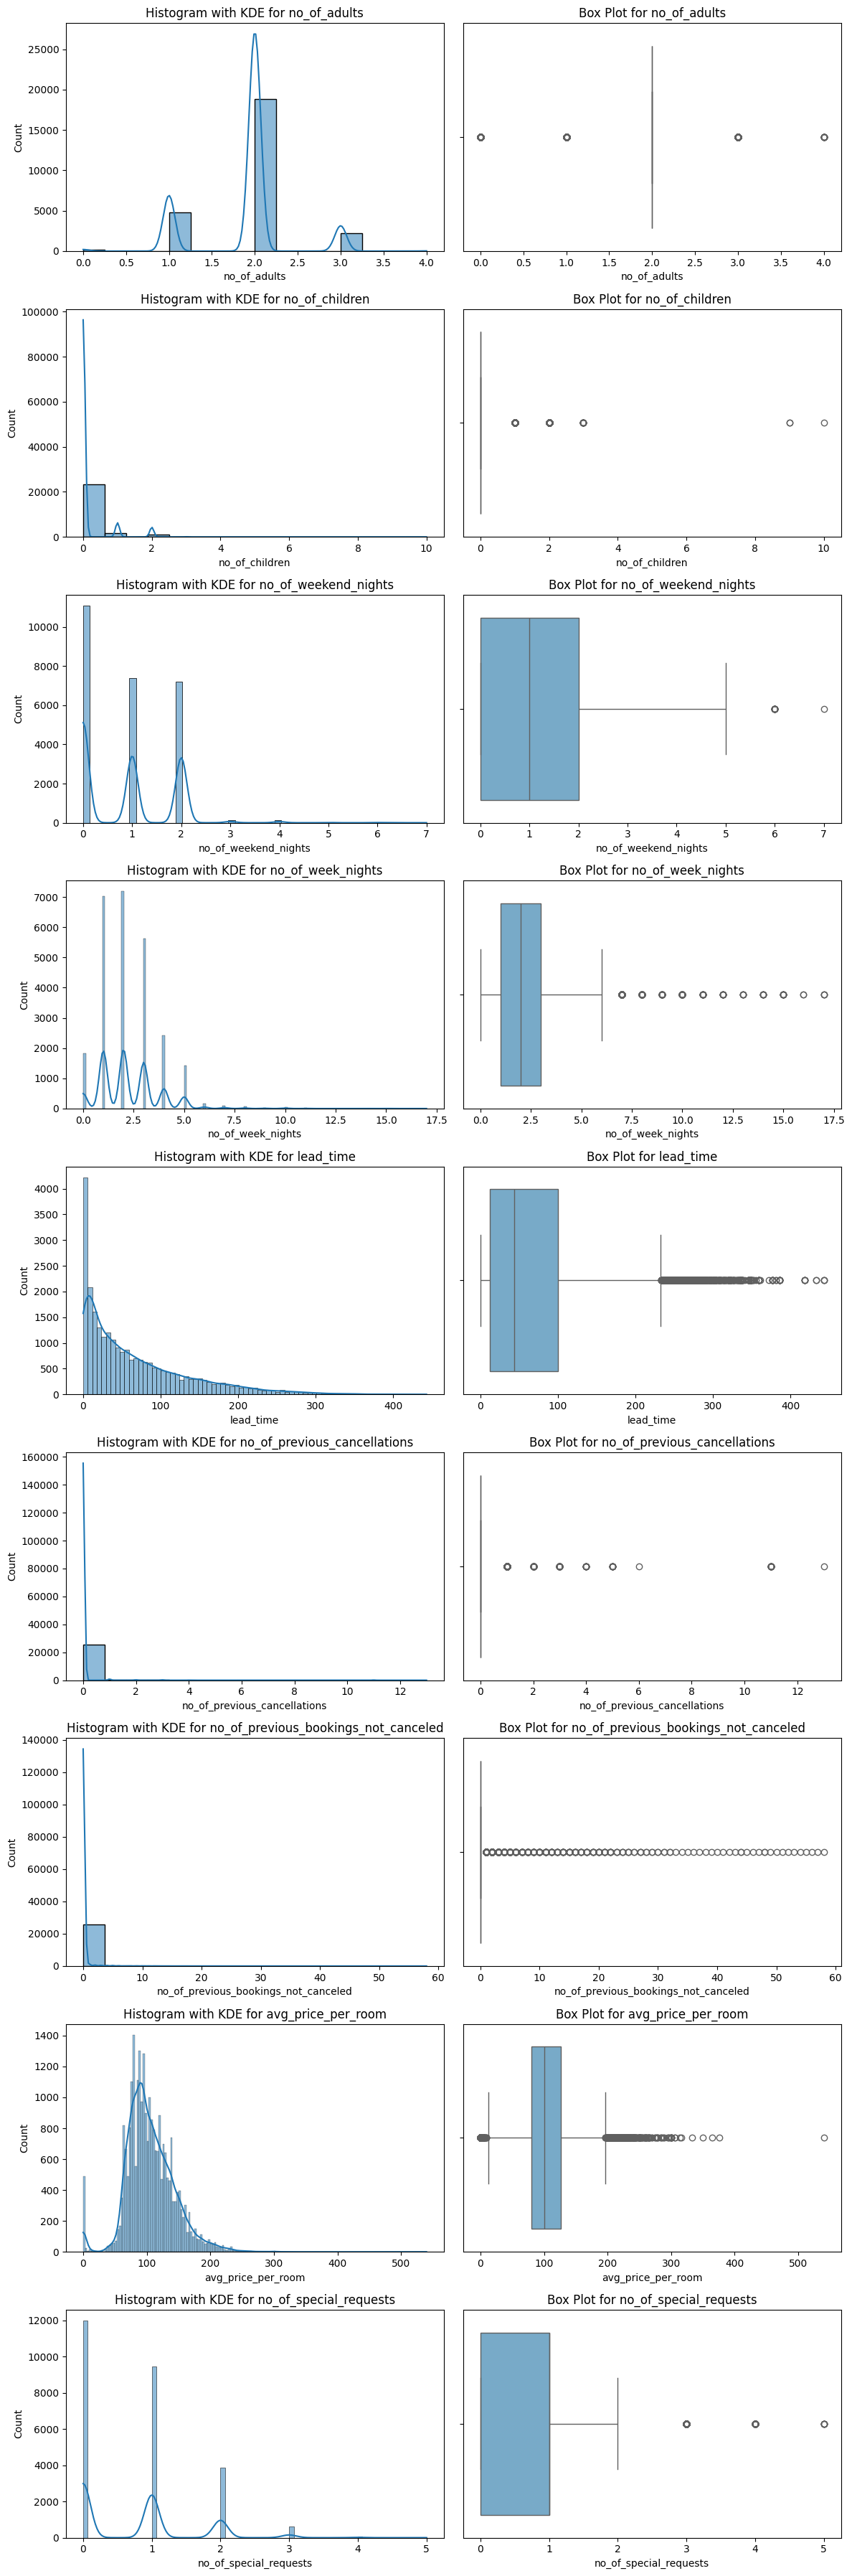

In [12]:
num_plot_dist(raw_data, numerical_cols)

- no_of_adults: For hotels their primary customers are couples as can be observed from the data they have the highest frequency of bookings followed by single and then family.
- no_of_children: The vast majority of bookings are for adults only, with a small number of bookings including children. This suggests a strong preference for adult-only travel and highlights a niche market for family-friendly accommodations.
- no_of_weekend_nights:The majority of bookings are for short weekend stays, with a few outliers indicating longer weekend getaways. This suggests a preference for quick weekend escapes and a niche market for extended weekend trips.
- avg_price_per_room: Majority of rooms being booked are more affordable and a smaller number of high-priced rooms are getting booked.
- no_of_special_requests: The vast majority of bookings have no special requests, with a few outliers indicating bookings with multiple special requests. This suggests that most customers have simple booking needs, while a small segment requires additional accommodations or preferences.

In [13]:
raw_data[raw_data['no_of_adults']==0]['no_of_children'].value_counts()

no_of_children
2    129
3      5
1      1
Name: count, dtype: int64

There are some instances in the data where it can be observed that sometimes rooms are booked by chlidren and no adults are involved.

#### Categorical Features

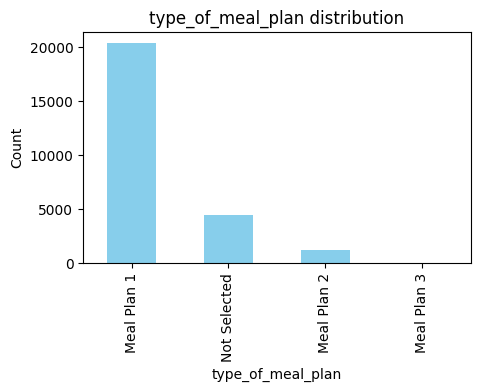

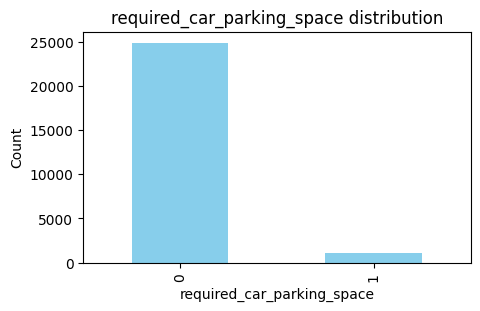

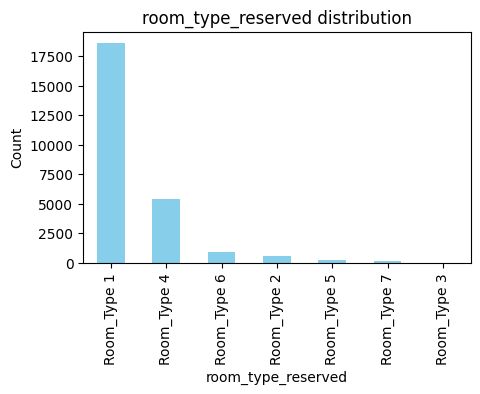

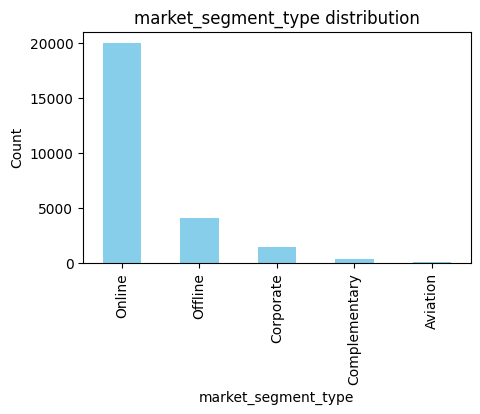

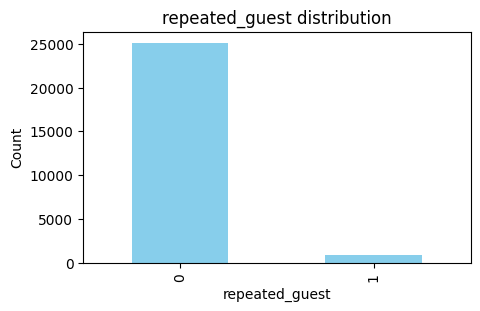

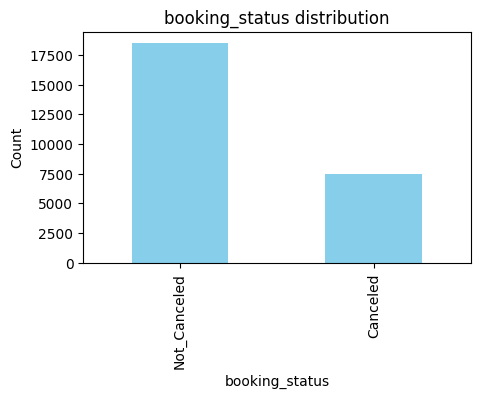

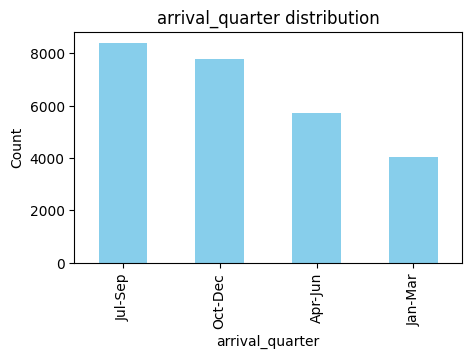

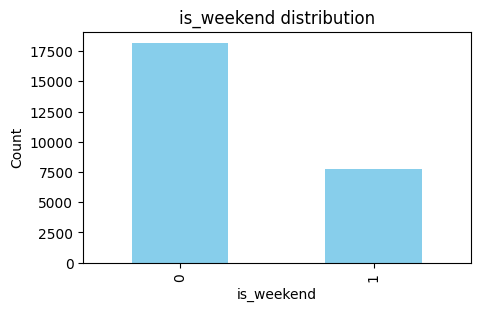

In [14]:
for cat_feature in categorical_cols:
        plt.figure(figsize=(5, 3))
        raw_data[cat_feature].value_counts().plot(kind='bar', color='skyblue')
        plt.title(f'{cat_feature} distribution')
        plt.xlabel(cat_feature)
        plt.ylabel('Count')
        plt.show()

The data indicates a clear seasonal pattern in bookings. There's a significant increase in bookings in the third quarter from July to September, peaking in August. This peak period is then followed by a decline in bookings, suggesting a potential high season for the business during these months.

### Bivariate Analysis

#### Numerical Features

In [15]:
def plot_box_target(df, target, num_features):
    num_plots = len(num_features)
    num_rows = (num_plots + 1) // 2  
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))
    
    axes = axes.flatten()
    
    for i, column in enumerate(num_features):
        sns.boxplot(x=target, y=column, ax=axes[i], data=df, palette="Blues")
        axes[i].set_title(f'{column} vs {target}')
    
    plt.tight_layout()
    plt.show()

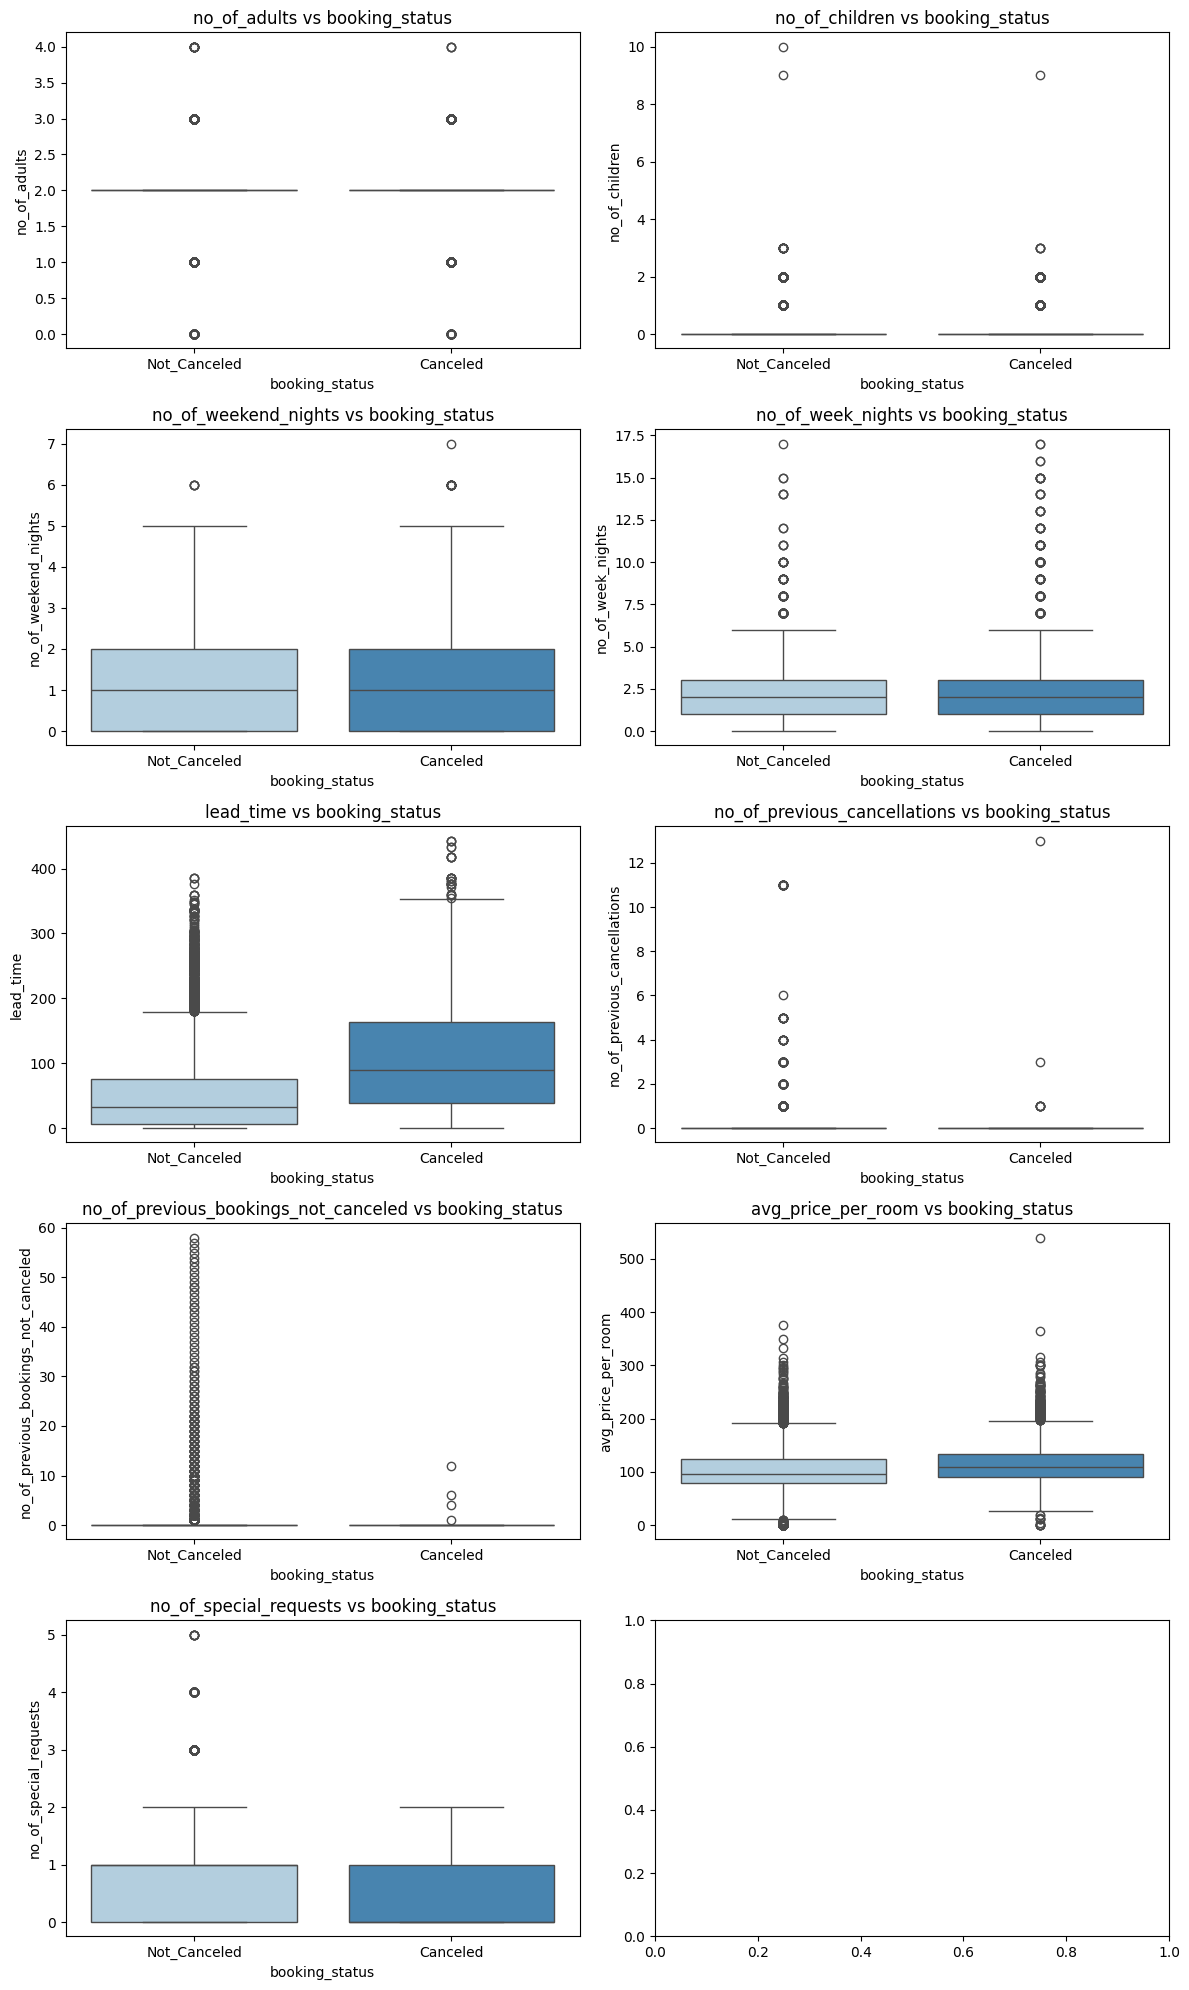

In [16]:
plot_box_target(raw_data, 'booking_status', numerical_cols)

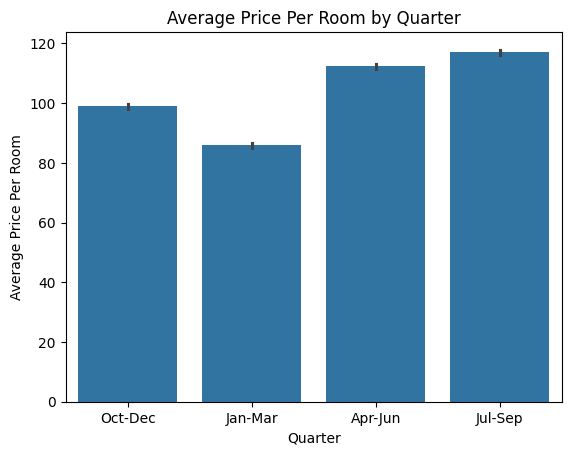

In [17]:
sns.barplot(x='arrival_quarter', y='avg_price_per_room',data=raw_data)
plt.xlabel('Quarter')
plt.ylabel('Average Price Per Room')
plt.title('Average Price Per Room by Quarter')
plt.show()

#### Categorical Features

In [18]:
def plot_cat_features_with_target(df, target, cat_features):
    num_features = len(cat_features)

    num_row = (num_features + 1) // 2

    fig, axes = plt.subplots(num_row, 2, figsize=(12, num_row * 5))
    
    
    axes = axes.flatten()

    for i, feature in enumerate(cat_features):
        sns.countplot(x=feature, hue=target, data=df, palette="Set2", ax=axes[i])
        axes[i].set_title(f'{feature} vs {target}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

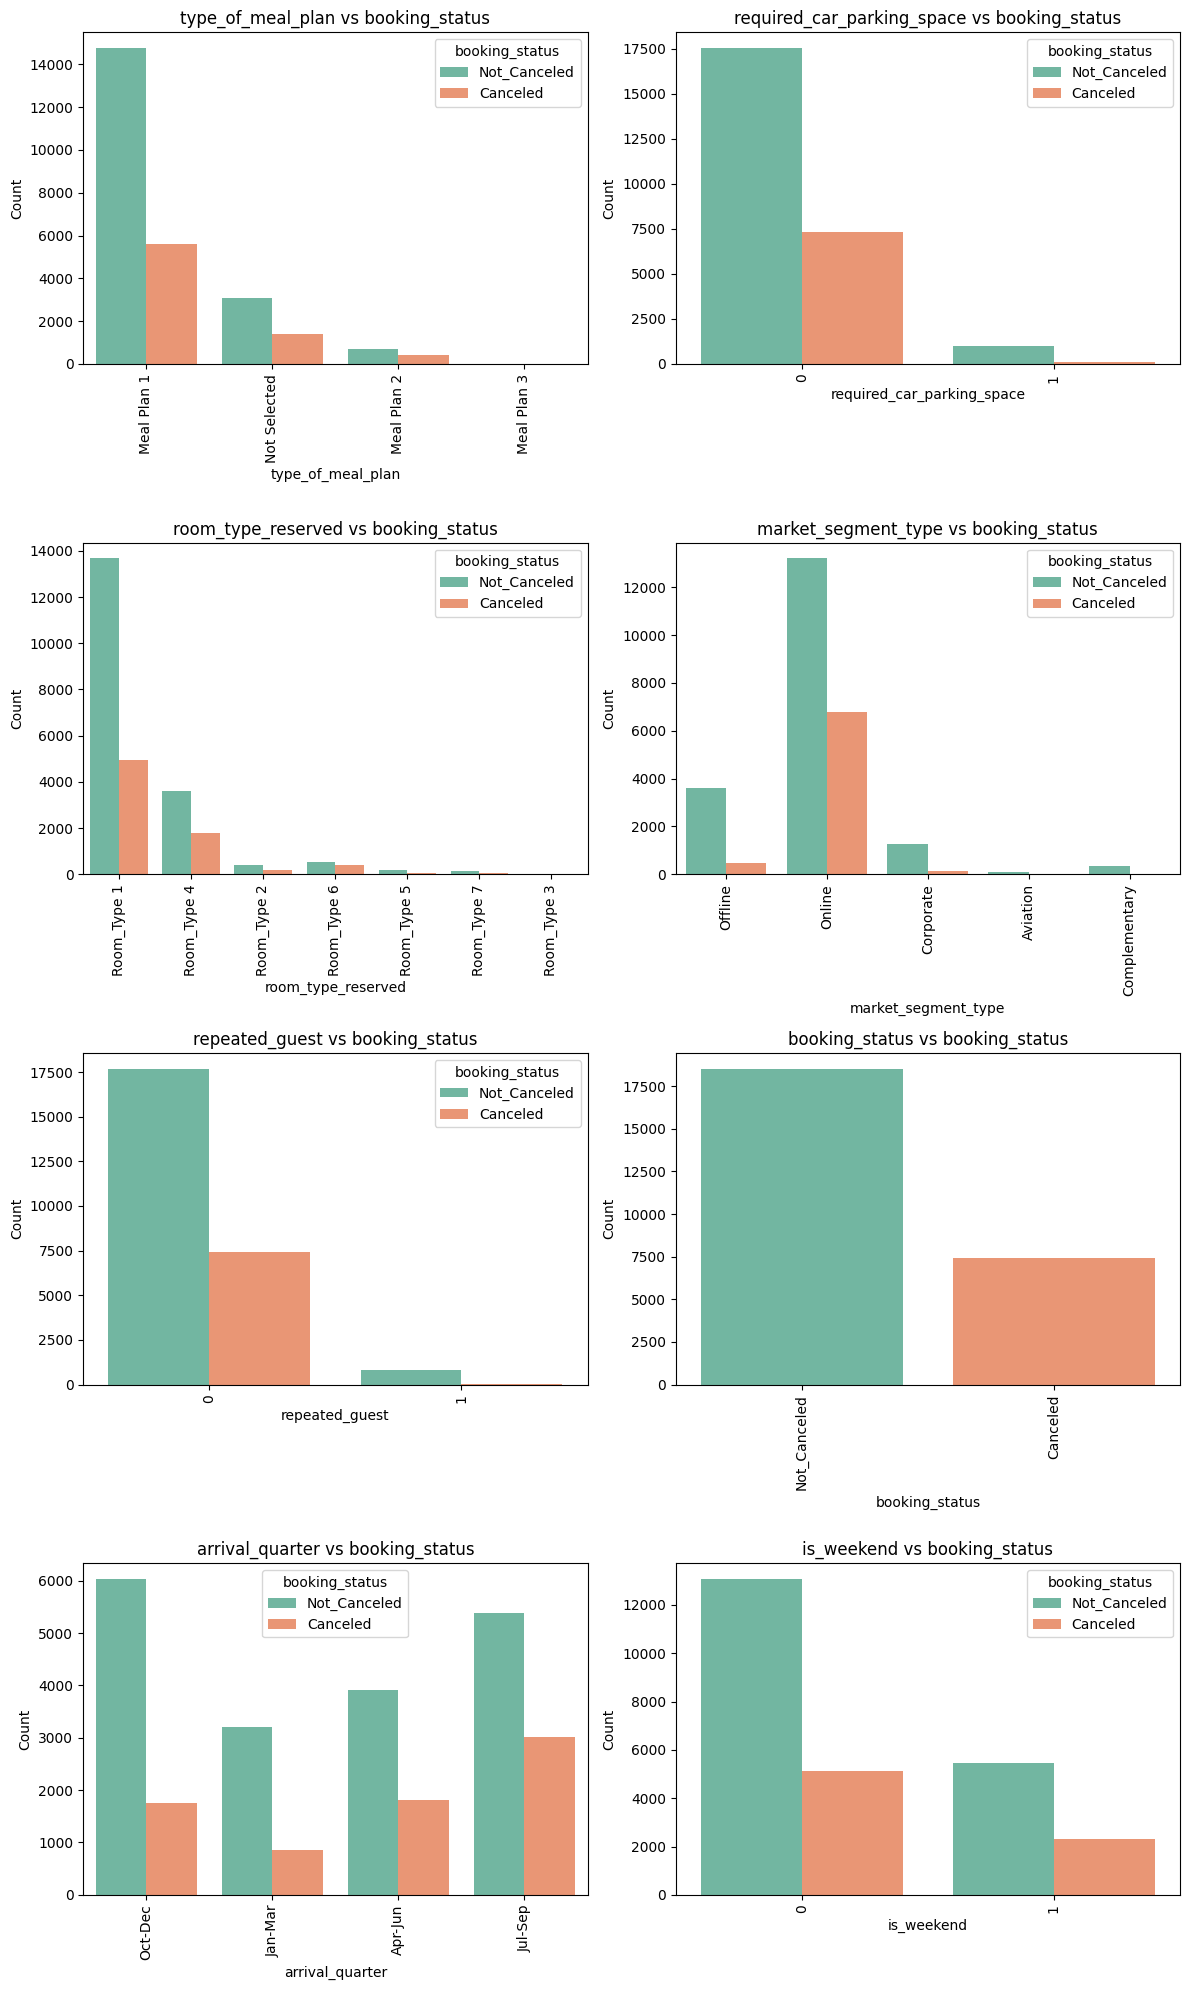

In [19]:
plot_cat_features_with_target(raw_data, 'booking_status', categorical_cols)

**Booking Cancellation Insights**

**Meal Plan**: Customers who choose "Not Selected" for their meal plan have a lower cancellation rate compared to those selecting a specific meal plan.

**Room Type**: "Room Type 1" has the highest cancellation rate.

**Market Segment**: "Complementary" bookings have a very low cancellation rate, while "Online" bookings tend to have a higher cancellation rate compared to offline bookings, possibly due to ease of cancellation, price comparisons, or flexible policies.

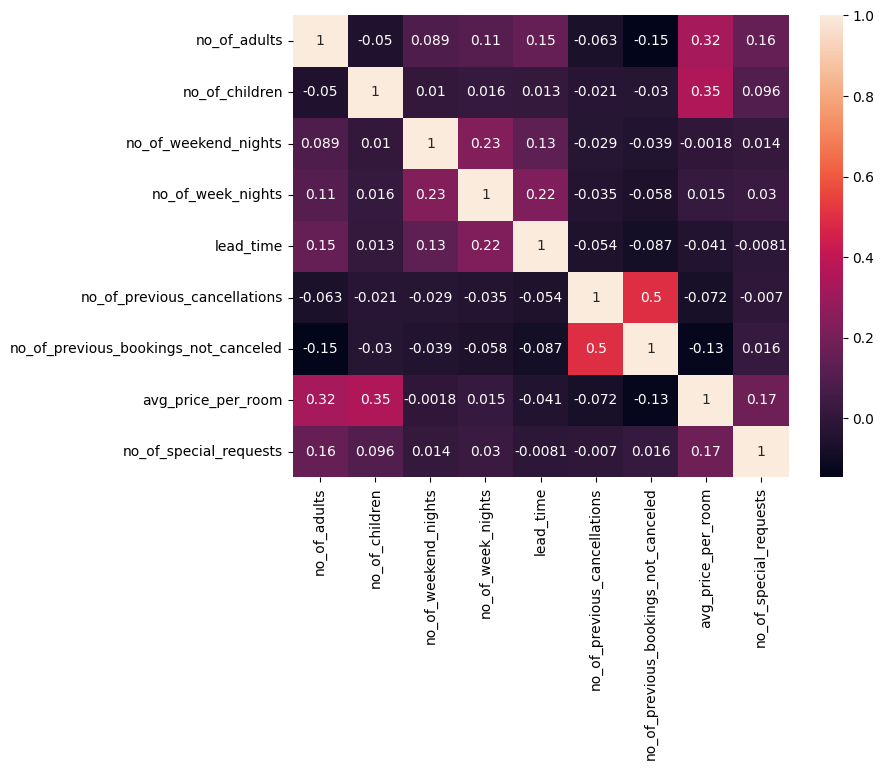

In [20]:
plt.figure(figsize=(8,6))
corr = raw_data[numerical_cols].corr()
sns.heatmap(corr, annot=True)
plt.show()

## Data Preprocessing

In [21]:
raw_data = pd.get_dummies(raw_data, columns=['type_of_meal_plan', 'room_type_reserved', 'market_segment_type',
                                             'arrival_quarter'], drop_first=True, dtype=int)
raw_data['booking_status'] = raw_data['booking_status'].map({'Not_Canceled': 0, 'Canceled': 1})

In [22]:
raw_data.sort_values('arrival_full_date', ascending=True, inplace=True, ignore_index=True)

In [23]:
# Spilitting data into train and test set
train_data = raw_data.loc[~(raw_data['arrival_full_date']>='2018-11-01')].reset_index(drop=True) 
test_data = raw_data.loc[raw_data['arrival_full_date']>='2018-11-01'].reset_index(drop=True)

print(f'train_data.shape is: ', train_data.shape)
print(f'test_data.shape is: ', test_data.shape)

train_data.shape is:  (22513, 33)
test_data.shape is:  (3452, 33)


In [24]:
train_data.drop(columns=['arrival_year', 'arrival_month', 'arrival_date', 'arrival_full_date'], axis=1, inplace=True)
test_data.drop(columns=['arrival_year', 'arrival_month', 'arrival_date', 'arrival_full_date'], axis=1, inplace=True)

In [25]:
X = train_data.drop(columns='booking_status')
y = train_data["booking_status"]

In [26]:
model =  RandomForestClassifier(random_state=42)
model.fit(X, y)

feature_importance_df = pd.DataFrame({
    'feature':X.columns,
    'importance':model.feature_importances_
})
features_importance_df = feature_importance_df.sort_values(by="importance" , ascending=False).reset_index(drop=True)

features_importance_df 

feature  importance
0                              lead_time    0.351851
1                     avg_price_per_room    0.205896
2                 no_of_special_requests    0.135493
3                      no_of_week_nights    0.065283
4                   no_of_weekend_nights    0.042454
5             market_segment_type_Online    0.034097
6                           no_of_adults    0.021812
7            market_segment_type_Offline    0.020480
8                             is_weekend    0.016705
9                arrival_quarter_Jul-Sep    0.014412
10        type_of_meal_plan_Not Selected    0.011773
11               arrival_quarter_Oct-Dec    0.011419
12        room_type_reserved_Room_Type 4    0.011142
13            required_car_parking_space    0.010729
14                        no_of_children    0.010366
15               arrival_quarter_Jan-Mar    0.009765
16         type_of_meal_plan_Meal Plan 2    0.005840
17         market_segment_type_Corporate    0.004128
18        room_type_reserved_Room_Type 2    0.003850
19        room_type_reserved_Room_Type 6    0.003064
20                        repeated_guest    0.002969
21        room_type_reserved_Room_Type 5    0.002530
22  no_of_previous_bookings_not_canceled    0.001956
23     market_segment_type_Complementary    0.000784
24        room_type_reserved_Room_Type 7    0.000740
25          no_of_previous_cancellations    0.000339
26         type_of_meal_plan_Meal Plan 3    0.000074
27        room_type_reserved_Room_Type 3    0.000053

In [27]:
top_features = features_importance_df["feature"].head(8).values

print('top features are: ', top_features)

train_data = train_data[top_features.tolist() + ["booking_status"]]
test_data = test_data[top_features.tolist() + ["booking_status"]]

top features are:  ['lead_time' 'avg_price_per_room' 'no_of_special_requests'
 'no_of_week_nights' 'no_of_weekend_nights' 'market_segment_type_Online'
 'no_of_adults' 'market_segment_type_Offline']


In [28]:
X_train, y_train = train_data.drop(columns='booking_status'), train_data["booking_status"]
X_test, y_test = test_data.drop(columns='booking_status'), test_data["booking_status"]

In [29]:
classifiers = {
    "Logistic Regression" : LogisticRegression(random_state=12, class_weight='balanced'),
    "Random Forest" : RandomForestClassifier(random_state=12, class_weight='balanced', bootstrap=False, n_jobs=-1),
    "Gradient Boosting" : GradientBoostingClassifier(random_state=12),
    "Decsion Tree" : DecisionTreeClassifier(random_state=12, class_weight='balanced'),
    "XGboost" : XGBClassifier(random_state=12,n_jobs=-1),
    "LGBM" : LGBMClassifier(random_state=12, class_weight='balanced', n_jobs=-1) 
}

metrics = {
    "model" : [],
    "avg_accuracy" : [],
    "avg_precision" : [],
    "avg_recall" : [],
    "avg_f1_score" : [],
    "avg_roc_auc_score" : []
}

In [30]:
tscv = TimeSeriesSplit(n_splits=5)

for model_name, classifier in classifiers.items():
    accuracy = []
    precision = []
    recall = []
    f1 = []
    auc_score =[]

    for fold, (train_index, val_index) in enumerate(tscv.split(X_train)):
        print(f" Model: {model_name}, Fold: {fold}")
        X_t, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index,:]
        y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        classifier.fit(X_t, y_t)
        y_pred = classifier.predict(X_val)
        
        accuracy.append(accuracy_score(y_val,y_pred))
        precision.append(precision_score(y_val,y_pred))
        recall.append(recall_score(y_val,y_pred))
        f1.append(f1_score(y_val, y_pred))
        auc_score.append(roc_auc_score(y_val, y_pred))
        
    metrics["model"].append(model_name)
    metrics["avg_accuracy"].append(np.mean(accuracy))
    metrics["avg_precision"].append(np.mean(precision))
    metrics["avg_recall"].append(np.mean(recall))
    metrics["avg_f1_score"].append(np.mean(f1))
    metrics["avg_roc_auc_score"].append(np.mean(auc_score))


 Model: Logistic Regression, Fold: 0
 Model: Logistic Regression, Fold: 1
 Model: Logistic Regression, Fold: 2
 Model: Logistic Regression, Fold: 3
 Model: Logistic Regression, Fold: 4
 Model: Random Forest, Fold: 0
 Model: Random Forest, Fold: 1
 Model: Random Forest, Fold: 2
 Model: Random Forest, Fold: 3
 Model: Random Forest, Fold: 4
 Model: Gradient Boosting, Fold: 0
 Model: Gradient Boosting, Fold: 1
 Model: Gradient Boosting, Fold: 2
 Model: Gradient Boosting, Fold: 3
 Model: Gradient Boosting, Fold: 4
 Model: Decsion Tree, Fold: 0
 Model: Decsion Tree, Fold: 1
 Model: Decsion Tree, Fold: 2
 Model: Decsion Tree, Fold: 3
 Model: Decsion Tree, Fold: 4
 Model: XGboost, Fold: 0
 Model: XGboost, Fold: 1
 Model: XGboost, Fold: 2
 Model: XGboost, Fold: 3
 Model: XGboost, Fold: 4
 Model: LGBM, Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `for

In [31]:
metrics_df = pd.DataFrame(metrics)
metrics_df

model  avg_accuracy  avg_precision  avg_recall  avg_f1_score  \
0  Logistic Regression      0.714286       0.538542    0.837329      0.648728   
1        Random Forest      0.777878       0.620315    0.500251      0.545717   
2    Gradient Boosting      0.814872       0.693337    0.539235      0.594543   
3         Decsion Tree      0.746215       0.566615    0.515007      0.537825   
4              XGboost      0.804744       0.678358    0.534572      0.584500   
5                 LGBM      0.768550       0.591362    0.719122      0.637324   

   avg_roc_auc_score  
0           0.741981  
1           0.691828  
2           0.728746  
3           0.674314  
4           0.720066  
5           0.743561

## Hyperparameter Tuning

In [32]:
tscv = TimeSeriesSplit(n_splits=5)

study = optuna.create_study(direction="maximize")

def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    num_leaves = trial.suggest_int("num_leaves", 2, 256)
    max_depth = trial.suggest_int("max_depth", -1, 20)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    n_estimators = trial.suggest_int("n_estimators", 100, 5000)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-5, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-5, 10.0, log=True)

    auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        print(f"Fold: {fold}")
        model = LGBMClassifier(
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            max_depth=max_depth,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            n_estimators=n_estimators,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            class_weight='balanced',
            random_state=12,
            n_jobs=-1,
        )
        model.fit(
            X_t, y_t,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            callbacks=[
                early_stopping(stopping_rounds=50),  # Early stopping
                log_evaluation(period=100),  # Log evaluation every 100 iterations
            ],
        )

        y_pred = model.predict_proba(X_val)[:, 1]  # Use probabilities for AUC
        
        auc_scores.append(roc_auc_score(y_val, y_pred))

    return np.mean(auc_scores)

study.optimize(objective, n_trials=50)

print("Best trial:", study.best_trial)
print("Highest AUC score value: {}".format(study.best_trial.value))
print("Best Params: {}".format(study.best_trial.params))

[I 2025-03-20 13:39:46,866] A new study created in memory with name: no-name-9784e247-4b21-471f-9204-7a907be48c8d


Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.694238	valid_0's binary_logloss: 0.636444
Fold: 1
[LightGBM] [Info] Number of positive: 1193, number of negative: 6312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 7505, number of u

[I 2025-03-20 13:39:49,393] Trial 0 finished with value: 0.8437146978919836 and parameters: {'learning_rate': 0.05659557678844036, 'num_leaves': 13, 'max_depth': 9, 'min_child_samples': 45, 'subsample': 0.9707877497883557, 'colsample_bytree': 0.7881190213488584, 'n_estimators': 2499, 'reg_alpha': 0.0037108069824760164, 'reg_lambda': 3.666721222144802e-05}. Best is trial 0 with value: 0.8437146978919836.


[300]	valid_0's auc: 0.910913	valid_0's binary_logloss: 0.352997
Early stopping, best iteration is:
[275]	valid_0's auc: 0.911338	valid_0's binary_logloss: 0.352699
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-03-20 13:39:55,205] Trial 1 finished with value: 0.8301262862001909 and parameters: {'learning_rate': 0.08983405689455343, 'num_leaves': 95, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.9294162709902838, 'colsample_bytree': 0.7264064141611095, 'n_estimators': 2090, 'reg_alpha': 0.07659362713980762, 'reg_lambda': 0.043002193025843995}. Best is trial 0 with value: 0.8437146978919836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[49]	valid_0's auc: 0.909628	valid_0's binary_logloss: 0.358545
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-03-20 13:39:57,483] Trial 2 finished with value: 0.8301673153122426 and parameters: {'learning_rate': 0.036595247431128804, 'num_leaves': 137, 'max_depth': 1, 'min_child_samples': 6, 'subsample': 0.9890353373075538, 'colsample_bytree': 0.847563932323258, 'n_estimators': 1132, 'reg_alpha': 0.0039267743209652475, 'reg_lambda': 0.23554520959087516}. Best is trial 0 with value: 0.8437146978919836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[800]	valid_0's auc: 0.892288	valid_0's binary_logloss: 0.423791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-03-20 13:40:10,093] Trial 3 finished with value: 0.831886883761382 and parameters: {'learning_rate': 0.01854116782602511, 'num_leaves': 211, 'max_depth': 18, 'min_child_samples': 31, 'subsample': 0.7181122365814072, 'colsample_bytree': 0.577099592503342, 'n_estimators': 4737, 'reg_alpha': 0.0641450738579426, 'reg_lambda': 3.6421708537417823}. Best is trial 0 with value: 0.8437146978919836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[76]	valid_0's auc: 0.900498	valid_0's binary_logloss: 0.465037
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores

[I 2025-03-20 13:40:17,593] Trial 4 finished with value: 0.8285599635833213 and parameters: {'learning_rate': 0.06239909054937446, 'num_leaves': 102, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.5931231365743816, 'colsample_bytree': 0.8728421221401976, 'n_estimators': 424, 'reg_alpha': 0.010201648789236371, 'reg_lambda': 0.5358931970224674}. Best is trial 0 with value: 0.8437146978919836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[67]	valid_0's auc: 0.909631	valid_0's binary_logloss: 0.356415
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-03-20 13:40:27,142] Trial 5 finished with value: 0.8352465722095364 and parameters: {'learning_rate': 0.03375291830936835, 'num_leaves': 138, 'max_depth': 15, 'min_child_samples': 95, 'subsample': 0.7735634837490071, 'colsample_bytree': 0.7438671087488973, 'n_estimators': 1069, 'reg_alpha': 1.6078710349864597e-05, 'reg_lambda': 0.1439252149785254}. Best is trial 0 with value: 0.8437146978919836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[147]	valid_0's auc: 0.905566	valid_0's binary_logloss: 0.365728
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of d

[I 2025-03-20 13:40:38,950] Trial 6 finished with value: 0.8179960601121339 and parameters: {'learning_rate': 0.09234405661084302, 'num_leaves': 210, 'max_depth': 20, 'min_child_samples': 6, 'subsample': 0.7214167024337439, 'colsample_bytree': 0.8772808521670438, 'n_estimators': 1385, 'reg_alpha': 1.1518822220955511e-05, 'reg_lambda': 0.36407290796981984}. Best is trial 0 with value: 0.8437146978919836.


Early stopping, best iteration is:
[26]	valid_0's auc: 0.907226	valid_0's binary_logloss: 0.373926
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-03-20 13:40:45,326] Trial 7 finished with value: 0.8395283152229636 and parameters: {'learning_rate': 0.02903617106533746, 'num_leaves': 182, 'max_depth': 5, 'min_child_samples': 46, 'subsample': 0.532362995151783, 'colsample_bytree': 0.5026947946623307, 'n_estimators': 546, 'reg_alpha': 0.008652114738533952, 'reg_lambda': 0.00015540396158623642}. Best is trial 0 with value: 0.8437146978919836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's auc: 0.9092	valid_0's binary_logloss: 0.361544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-03-20 13:40:48,991] Trial 8 finished with value: 0.8419223411248098 and parameters: {'learning_rate': 0.03482791709296105, 'num_leaves': 146, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.5235752689227309, 'colsample_bytree': 0.5136897930228208, 'n_estimators': 4609, 'reg_alpha': 0.09402805309748784, 'reg_lambda': 0.8003055604304133}. Best is trial 0 with value: 0.8437146978919836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:40:52,767] Trial 9 finished with value: 0.8455552609326787 and parameters: {'learning_rate': 0.02798327023238638, 'num_leaves': 237, 'max_depth': 5, 'min_child_samples': 99, 'subsample': 0.7654529477973308, 'colsample_bytree': 0.9969452768416298, 'n_estimators': 3013, 'reg_alpha': 3.747433249347985e-05, 'reg_lambda': 0.0003468972894019589}. Best is trial 9 with value: 0.8455552609326787.


Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-03-20 13:41:11,781] Trial 10 finished with value: 0.8336532198797354 and parameters: {'learning_rate': 0.00911948266424948, 'num_leaves': 249, 'max_depth': -1, 'min_child_samples': 98, 'subsample': 0.8424164187648354, 'colsample_bytree': 0.9665108946300873, 'n_estimators': 3615, 'reg_alpha': 0.00016678294277378342, 'reg_lambda': 0.0019137770129590097}. Best is trial 9 with value: 0.8455552609326787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[90]	valid_0's auc: 0.895463	valid_0's binary_logloss: 0.47708
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in

[I 2025-03-20 13:41:14,187] Trial 11 finished with value: 0.8416281613738661 and parameters: {'learning_rate': 0.060918521799484544, 'num_leaves': 3, 'max_depth': 8, 'min_child_samples': 68, 'subsample': 0.8667444364777791, 'colsample_bytree': 0.9927713392593772, 'n_estimators': 3069, 'reg_alpha': 6.8905978588585635, 'reg_lambda': 1.920584618443022e-05}. Best is trial 9 with value: 0.8455552609326787.


[700]	valid_0's auc: 0.905981	valid_0's binary_logloss: 0.381349
Early stopping, best iteration is:
[705]	valid_0's auc: 0.906012	valid_0's binary_logloss: 0.381203
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.689855	valid_0's binary_logloss: 0.590279
Fold: 1
[LightGBM] [Info] Number of positive: 1193, number of negative: 6312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.


[I 2025-03-20 13:41:17,194] Trial 12 finished with value: 0.8433139640718583 and parameters: {'learning_rate': 0.057501438082423, 'num_leaves': 12, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.648214560512253, 'colsample_bytree': 0.6717088060003282, 'n_estimators': 2304, 'reg_alpha': 0.0007689220422506111, 'reg_lambda': 0.0009069209403727019}. Best is trial 9 with value: 0.8455552609326787.


Early stopping, best iteration is:
[139]	valid_0's auc: 0.907389	valid_0's binary_logloss: 0.366079
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2025-03-20 13:41:19,954] Trial 13 finished with value: 0.845706853555523 and parameters: {'learning_rate': 0.0751908515374414, 'num_leaves': 53, 'max_depth': 6, 'min_child_samples': 49, 'subsample': 0.9941339286881463, 'colsample_bytree': 0.8093191975550127, 'n_estimators': 3324, 'reg_alpha': 8.751225700905838e-05, 'reg_lambda': 1.541815288276607e-05}. Best is trial 13 with value: 0.845706853555523.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:41:22,146] Trial 14 finished with value: 0.846396472954777 and parameters: {'learning_rate': 0.07551821168859872, 'num_leaves': 63, 'max_depth': 5, 'min_child_samples': 74, 'subsample': 0.841605632487104, 'colsample_bytree': 0.9312224303139813, 'n_estimators': 3753, 'reg_alpha': 8.583866456253806e-05, 'reg_lambda': 0.00022464726929338083}. Best is trial 14 with value: 0.846396472954777.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's auc: 0.910454	valid_0's binary_logloss: 0.354299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-03-20 13:41:23,320] Trial 15 finished with value: 0.8416878837850005 and parameters: {'learning_rate': 0.08075105456746969, 'num_leaves': 53, 'max_depth': 2, 'min_child_samples': 68, 'subsample': 0.8786304917344847, 'colsample_bytree': 0.9113385338711139, 'n_estimators': 3939, 'reg_alpha': 0.0001784131123331085, 'reg_lambda': 1.0443662720030481e-05}. Best is trial 14 with value: 0.846396472954777.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:41:26,660] Trial 16 finished with value: 0.842461582471621 and parameters: {'learning_rate': 0.07555620038846173, 'num_leaves': 54, 'max_depth': 7, 'min_child_samples': 80, 'subsample': 0.8286414319100622, 'colsample_bytree': 0.8077126997747207, 'n_estimators': 3993, 'reg_alpha': 0.00018801727119305403, 'reg_lambda': 0.009893285112218708}. Best is trial 14 with value: 0.846396472954777.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:41:31,180] Trial 17 finished with value: 0.8379133380050021 and parameters: {'learning_rate': 0.07130974406019966, 'num_leaves': 56, 'max_depth': 12, 'min_child_samples': 55, 'subsample': 0.9379448263757122, 'colsample_bytree': 0.9238173936454931, 'n_estimators': 3257, 'reg_alpha': 0.0007525473242425189, 'reg_lambda': 9.593186469928558e-05}. Best is trial 14 with value: 0.846396472954777.


Early stopping, best iteration is:
[75]	valid_0's auc: 0.909538	valid_0's binary_logloss: 0.354454
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-03-20 13:41:32,722] Trial 18 finished with value: 0.8449562242975768 and parameters: {'learning_rate': 0.0991102897220801, 'num_leaves': 99, 'max_depth': 2, 'min_child_samples': 57, 'subsample': 0.9013607496656322, 'colsample_bytree': 0.8177953975324429, 'n_estimators': 4239, 'reg_alpha': 5.047586115191379e-05, 'reg_lambda': 0.004039050984862462}. Best is trial 14 with value: 0.846396472954777.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:41:35,986] Trial 19 finished with value: 0.843994167693554 and parameters: {'learning_rate': 0.049875396441444717, 'num_leaves': 77, 'max_depth': 6, 'min_child_samples': 85, 'subsample': 0.8048637497538879, 'colsample_bytree': 0.6698768095898003, 'n_estimators': 1901, 'reg_alpha': 1.904453746761685, 'reg_lambda': 0.00039419416036076763}. Best is trial 14 with value: 0.846396472954777.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:41:39,801] Trial 20 finished with value: 0.8374180241945304 and parameters: {'learning_rate': 0.08294538212316657, 'num_leaves': 36, 'max_depth': -1, 'min_child_samples': 36, 'subsample': 0.9939465169098937, 'colsample_bytree': 0.9284712260254143, 'n_estimators': 4997, 'reg_alpha': 0.0007189449989907332, 'reg_lambda': 5.045854021238256e-05}. Best is trial 14 with value: 0.846396472954777.


[100]	valid_0's auc: 0.909867	valid_0's binary_logloss: 0.352148
Early stopping, best iteration is:
[62]	valid_0's auc: 0.910544	valid_0's binary_logloss: 0.354867
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-03-20 13:41:43,322] Trial 21 finished with value: 0.8467966045157919 and parameters: {'learning_rate': 0.04693108646964601, 'num_leaves': 166, 'max_depth': 4, 'min_child_samples': 83, 'subsample': 0.6743843756885508, 'colsample_bytree': 0.9796619476940818, 'n_estimators': 2949, 'reg_alpha': 4.394064296896669e-05, 'reg_lambda': 0.0001729246880676555}. Best is trial 21 with value: 0.8467966045157919.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:41:45,425] Trial 22 finished with value: 0.8480629736943094 and parameters: {'learning_rate': 0.07082802332679852, 'num_leaves': 164, 'max_depth': 4, 'min_child_samples': 80, 'subsample': 0.6390399581161292, 'colsample_bytree': 0.9472801683350736, 'n_estimators': 3492, 'reg_alpha': 6.283001781950793e-05, 'reg_lambda': 0.00018203634909697925}. Best is trial 22 with value: 0.8480629736943094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[179]	valid_0's auc: 0.90722	valid_0's binary_logloss: 0.364091
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove th

[I 2025-03-20 13:41:47,389] Trial 23 finished with value: 0.8442308866352637 and parameters: {'learning_rate': 0.045453844000590674, 'num_leaves': 174, 'max_depth': 3, 'min_child_samples': 83, 'subsample': 0.643669057546175, 'colsample_bytree': 0.9449635544377022, 'n_estimators': 2809, 'reg_alpha': 1.0777528754983263e-05, 'reg_lambda': 0.0005975442058729244}. Best is trial 22 with value: 0.8480629736943094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:41:53,734] Trial 24 finished with value: 0.8388451541474999 and parameters: {'learning_rate': 0.06553765835993927, 'num_leaves': 161, 'max_depth': 11, 'min_child_samples': 76, 'subsample': 0.6618668127918211, 'colsample_bytree': 0.8909673336377245, 'n_estimators': 3638, 'reg_alpha': 0.0004707087622201973, 'reg_lambda': 0.0001704878878064293}. Best is trial 22 with value: 0.8480629736943094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[122]	valid_0's auc: 0.909822	valid_0's binary_logloss: 0.353276
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove t

[I 2025-03-20 13:41:55,487] Trial 25 finished with value: 0.831202602463941 and parameters: {'learning_rate': 0.043390906287476855, 'num_leaves': 195, 'max_depth': 1, 'min_child_samples': 89, 'subsample': 0.5895618093096349, 'colsample_bytree': 0.957626095908755, 'n_estimators': 2760, 'reg_alpha': 3.75909212988803e-05, 'reg_lambda': 0.002154186709791367}. Best is trial 22 with value: 0.8480629736943094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:41:57,446] Trial 26 finished with value: 0.8434384565593434 and parameters: {'learning_rate': 0.06960002335536426, 'num_leaves': 122, 'max_depth': 4, 'min_child_samples': 73, 'subsample': 0.6919955685893917, 'colsample_bytree': 0.853722847192716, 'n_estimators': 4310, 'reg_alpha': 0.0018507691422705497, 'reg_lambda': 0.021529270333721953}. Best is trial 22 with value: 0.8480629736943094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:42:01,607] Trial 27 finished with value: 0.8463067719800209 and parameters: {'learning_rate': 0.05287747870242456, 'num_leaves': 116, 'max_depth': 7, 'min_child_samples': 60, 'subsample': 0.5770356684390983, 'colsample_bytree': 0.9994290673998205, 'n_estimators': 3642, 'reg_alpha': 7.248431207007194e-05, 'reg_lambda': 5.825371068635769e-05}. Best is trial 22 with value: 0.8480629736943094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[134]	valid_0's auc: 0.911422	valid_0's binary_logloss: 0.352098
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [I

[I 2025-03-20 13:42:08,029] Trial 28 finished with value: 0.8380428034254912 and parameters: {'learning_rate': 0.08242896636302956, 'num_leaves': 162, 'max_depth': 0, 'min_child_samples': 88, 'subsample': 0.6171411769740938, 'colsample_bytree': 0.9595156198175123, 'n_estimators': 1707, 'reg_alpha': 0.00031975850883511994, 'reg_lambda': 0.005067298898602762}. Best is trial 22 with value: 0.8480629736943094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[43]	valid_0's auc: 0.903637	valid_0's binary_logloss: 0.36789
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-03-20 13:42:15,028] Trial 29 finished with value: 0.8395390251349074 and parameters: {'learning_rate': 0.05624996791749186, 'num_leaves': 153, 'max_depth': 10, 'min_child_samples': 62, 'subsample': 0.7922549254778054, 'colsample_bytree': 0.7783200856041178, 'n_estimators': 2523, 'reg_alpha': 2.8108588764199492e-05, 'reg_lambda': 3.1342404868745374e-05}. Best is trial 22 with value: 0.8480629736943094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:42:16,522] Trial 30 finished with value: 0.8455341482959217 and parameters: {'learning_rate': 0.06663832820856466, 'num_leaves': 220, 'max_depth': 3, 'min_child_samples': 76, 'subsample': 0.735632943211783, 'colsample_bytree': 0.9042503696813841, 'n_estimators': 3407, 'reg_alpha': 0.0020600265584787853, 'reg_lambda': 0.00127008889435178}. Best is trial 22 with value: 0.8480629736943094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:42:21,007] Trial 31 finished with value: 0.8423781556294017 and parameters: {'learning_rate': 0.051791887481032466, 'num_leaves': 121, 'max_depth': 8, 'min_child_samples': 62, 'subsample': 0.5647204935390118, 'colsample_bytree': 0.9960002672849175, 'n_estimators': 3784, 'reg_alpha': 7.983724248403749e-05, 'reg_lambda': 5.86208431755059e-05}. Best is trial 22 with value: 0.8480629736943094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[125]	valid_0's auc: 0.909972	valid_0's binary_logloss: 0.353113
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2025-03-20 13:42:25,046] Trial 32 finished with value: 0.8426521748346163 and parameters: {'learning_rate': 0.04270721760394335, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 91, 'subsample': 0.6870542841796964, 'colsample_bytree': 0.9762004695595544, 'n_estimators': 4231, 'reg_alpha': 0.00010059633045209395, 'reg_lambda': 0.00020712846405184206}. Best is trial 22 with value: 0.8480629736943094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:42:27,778] Trial 33 finished with value: 0.8509667189412976 and parameters: {'learning_rate': 0.054299655598319736, 'num_leaves': 84, 'max_depth': 5, 'min_child_samples': 63, 'subsample': 0.5034214615126693, 'colsample_bytree': 0.9343692908204079, 'n_estimators': 2811, 'reg_alpha': 2.2123131986500293e-05, 'reg_lambda': 7.493997948193307e-05}. Best is trial 33 with value: 0.8509667189412976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:42:29,877] Trial 34 finished with value: 0.8461804745619641 and parameters: {'learning_rate': 0.07764139644772754, 'num_leaves': 84, 'max_depth': 4, 'min_child_samples': 78, 'subsample': 0.6201787915054591, 'colsample_bytree': 0.9316451636272135, 'n_estimators': 2203, 'reg_alpha': 2.2991321925974147e-05, 'reg_lambda': 0.00034617825747445906}. Best is trial 33 with value: 0.8509667189412976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:42:31,338] Trial 35 finished with value: 0.8424186611060355 and parameters: {'learning_rate': 0.08722211985762633, 'num_leaves': 74, 'max_depth': 2, 'min_child_samples': 37, 'subsample': 0.548289809830725, 'colsample_bytree': 0.8663149853003732, 'n_estimators': 2817, 'reg_alpha': 0.032043795240706156, 'reg_lambda': 0.00011603541631824454}. Best is trial 33 with value: 0.8509667189412976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:42:33,722] Trial 36 finished with value: 0.8468251386689808 and parameters: {'learning_rate': 0.05957031137183081, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 71, 'subsample': 0.5009198906721778, 'colsample_bytree': 0.8390162702605088, 'n_estimators': 2532, 'reg_alpha': 0.28230719223886225, 'reg_lambda': 2.8569801940568707e-05}. Best is trial 33 with value: 0.8509667189412976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:42:35,136] Trial 37 finished with value: 0.8319691511680102 and parameters: {'learning_rate': 0.06059563625050774, 'num_leaves': 26, 'max_depth': 1, 'min_child_samples': 66, 'subsample': 0.5215866382946449, 'colsample_bytree': 0.8418791818226747, 'n_estimators': 2431, 'reg_alpha': 0.4746703115809607, 'reg_lambda': 2.262338398208791e-05}. Best is trial 33 with value: 0.8509667189412976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:42:43,016] Trial 38 finished with value: 0.8374291163553078 and parameters: {'learning_rate': 0.04781920973659597, 'num_leaves': 133, 'max_depth': 15, 'min_child_samples': 82, 'subsample': 0.5067766318962648, 'colsample_bytree': 0.8938809928881897, 'n_estimators': 2051, 'reg_alpha': 0.1689182514706241, 'reg_lambda': 0.0523761098350527}. Best is trial 33 with value: 0.8509667189412976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[127]	valid_0's auc: 0.908699	valid_0's binary_logloss: 0.356115
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation score

[I 2025-03-20 13:42:44,638] Trial 39 finished with value: 0.8398626879124578 and parameters: {'learning_rate': 0.040889135963309266, 'num_leaves': 188, 'max_depth': 3, 'min_child_samples': 94, 'subsample': 0.6131402250336245, 'colsample_bytree': 0.744203123789194, 'n_estimators': 2638, 'reg_alpha': 0.01852732274334688, 'reg_lambda': 3.543571930803513e-05}. Best is trial 33 with value: 0.8509667189412976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:42:48,105] Trial 40 finished with value: 0.8458564642505495 and parameters: {'learning_rate': 0.0379307414729673, 'num_leaves': 35, 'max_depth': 6, 'min_child_samples': 51, 'subsample': 0.5583341297383648, 'colsample_bytree': 0.706942119034539, 'n_estimators': 3098, 'reg_alpha': 0.28326021659847667, 'reg_lambda': 2.954536554758328}. Best is trial 33 with value: 0.8509667189412976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's auc: 0.909111	valid_0's binary_logloss: 0.359566
Early stopping, best iteration is:
[150]	valid_0's auc: 0.90952	valid_0's binary_logloss: 0.36132
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with

[I 2025-03-20 13:42:50,838] Trial 41 finished with value: 0.8453596346777943 and parameters: {'learning_rate': 0.0558930861253443, 'num_leaves': 67, 'max_depth': 5, 'min_child_samples': 72, 'subsample': 0.5040194478738601, 'colsample_bytree': 0.9399905232655131, 'n_estimators': 3424, 'reg_alpha': 1.8285677021429155e-05, 'reg_lambda': 8.49768658419225e-05}. Best is trial 33 with value: 0.8509667189412976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:42:53,755] Trial 42 finished with value: 0.8489398718602462 and parameters: {'learning_rate': 0.06414225944852987, 'num_leaves': 37, 'max_depth': 5, 'min_child_samples': 73, 'subsample': 0.7498432565486796, 'colsample_bytree': 0.8385192063120278, 'n_estimators': 2907, 'reg_alpha': 0.8170465851817865, 'reg_lambda': 0.0002132818058012176}. Best is trial 33 with value: 0.8509667189412976.


Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-03-20 13:42:56,782] Trial 43 finished with value: 0.8398926456467534 and parameters: {'learning_rate': 0.06500224062500498, 'num_leaves': 21, 'max_depth': 8, 'min_child_samples': 65, 'subsample': 0.7013307938881431, 'colsample_bytree': 0.7826460678050439, 'n_estimators': 3024, 'reg_alpha': 1.3963952043507477, 'reg_lambda': 0.0006445219972820558}. Best is trial 33 with value: 0.8509667189412976.


Early stopping, best iteration is:
[186]	valid_0's auc: 0.909594	valid_0's binary_logloss: 0.355584
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2025-03-20 13:42:59,372] Trial 44 finished with value: 0.8441995913757427 and parameters: {'learning_rate': 0.05979659149332409, 'num_leaves': 37, 'max_depth': 4, 'min_child_samples': 85, 'subsample': 0.7396441556260082, 'colsample_bytree': 0.8455048745241333, 'n_estimators': 1544, 'reg_alpha': 0.9206317895006663, 'reg_lambda': 1.047223360418621e-05}. Best is trial 33 with value: 0.8509667189412976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:43:09,120] Trial 45 finished with value: 0.8411570227871316 and parameters: {'learning_rate': 0.026973797688218743, 'num_leaves': 203, 'max_depth': 10, 'min_child_samples': 71, 'subsample': 0.6684455932052575, 'colsample_bytree': 0.8784985317076889, 'n_estimators': 2358, 'reg_alpha': 5.788951910447344, 'reg_lambda': 9.75950828628278e-05}. Best is trial 33 with value: 0.8509667189412976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[270]	valid_0's auc: 0.908866	valid_0's binary_logloss: 0.359238
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM

[I 2025-03-20 13:43:11,708] Trial 46 finished with value: 0.8441493511010887 and parameters: {'learning_rate': 0.06928085426038343, 'num_leaves': 89, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.7622088291988263, 'colsample_bytree': 0.8298621043077161, 'n_estimators': 2892, 'reg_alpha': 0.07442942605798421, 'reg_lambda': 3.002820744974959e-05}. Best is trial 33 with value: 0.8509667189412976.


Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-03-20 13:43:14,536] Trial 47 finished with value: 0.8465263699933491 and parameters: {'learning_rate': 0.05399383857396998, 'num_leaves': 170, 'max_depth': 5, 'min_child_samples': 80, 'subsample': 0.5373781487126774, 'colsample_bytree': 0.9727957460539802, 'n_estimators': 2584, 'reg_alpha': 0.5799210177355091, 'reg_lambda': 0.00025455433709397127}. Best is trial 33 with value: 0.8509667189412976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-20 13:43:15,087] Trial 48 finished with value: 0.788273596790779 and parameters: {'learning_rate': 0.0012248935977266645, 'num_leaves': 4, 'max_depth': 0, 'min_child_samples': 94, 'subsample': 0.7063743532704697, 'colsample_bytree': 0.7667080904186117, 'n_estimators': 3159, 'reg_alpha': 2.0919718585814957, 'reg_lambda': 0.0005943722995745275}. Best is trial 33 with value: 0.8509667189412976.


Early stopping, best iteration is:
[103]	valid_0's auc: 0.851006	valid_0's binary_logloss: 0.663771
Fold: 0
[LightGBM] [Info] Number of positive: 472, number of negative: 3281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 3753, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2025-03-20 13:43:17,690] Trial 49 finished with value: 0.844283970059483 and parameters: {'learning_rate': 0.03235925237913616, 'num_leaves': 148, 'max_depth': 4, 'min_child_samples': 45, 'subsample': 0.5968730279373228, 'colsample_bytree': 0.7194964713945471, 'n_estimators': 924, 'reg_alpha': 0.004777671959247194, 'reg_lambda': 0.0014877823110762101}. Best is trial 33 with value: 0.8509667189412976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Final model west best hyperparams

In [33]:
final_model = LGBMClassifier(**study.best_trial.params, class_weight='balanced', random_state=12, n_jobs=-1)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

[LightGBM] [Info] Number of positive: 6647, number of negative: 15866
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 22513, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [34]:
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
auc_score = roc_auc_score(y_test, y_pred)

In [35]:
print(f"Accuracy on test set is: {accuracy}")
print(f"Precision on test set is: {precision}")
print(f"Recall on test set is: {recall}")
print(f"F1-score on test set is: {f1}")
print(f"ROC-AUC score on test set is: {auc_score}")

Accuracy on test set is: 0.7934530706836617
Precision on test set is: 0.5442739079102715
Recall on test set is: 0.5850253807106599
F1-score on test set is: 0.563914373088685
ROC-AUC score on test set is: 0.7200652429078824
